In [4]:
import keras
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
#from sklearn.metrics import classification_report, confusion_matrix
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import roc_curve
#from sklearn.metrics import roc_auc_score
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
%matplotlib inline

(x_train, y_train), (x_test, y_test) = mnist.load_data() #cargar los datos de mnist
X=np.concatenate((x_train, x_test), axis=0) #juntamos todos los datos
y=np.concatenate((y_train, y_test), axis=0)
#seleccionamos aleatoriamente 
X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.05, random_state=42) 

#plt.hist(y_train)
#plt.show()

img_width = img_height = X_train[0].shape[0]
X_train = X_train.reshape(X_train.shape[0], img_width*img_height) #transformamos la matriz
X_train=X_train/255 # scale RGB values in [0,1]
scaler = StandardScaler()
# Ajustamos en datos de entrenamiento
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train ,y_train)
# Obtenemos las representaciones
# datos de entrenamiento
X_train = lda.transform(X_train)
# svm
svm = SVC(kernel='rbf', C=5,gamma=0.1)
svm.fit(X_train,y_train)

            


SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [5]:
from tkinter import *
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import cv2
from ipywidgets import Output
from IPython.display import display, clear_output
out = Output()

class digits_representation(Frame):
    """Handwritten digits representation and visualization class"""
    def __init__(self, parent):
            Frame.__init__(self, parent)
            self.parent = parent
            self.color = "black"
            self.brush_size = 12
            self.setUI()
    def set_color(self, new_color):
            """Additional brush color change"""
            self.color = new_color
    def set_brush_size(self, new_size):
            """Changes brush size for testing different lines width"""
            self.brush_size = new_size
    def draw(self, event):
            """Method to draw"""
            self.canv.create_oval(event.x - self.brush_size, event.y - self.brush_size,
                                  event.x + self.brush_size, event.y + self.brush_size,
                                  fill=self.color, outline=self.color)
    def save(self):
            """Save the current canvas state as the postscript
            uses project method and shows the result"""
            self.canv.update()
            ps = self.canv.postscript(colormode='mono')
            img = Image.open(io.BytesIO(ps.encode('utf-8')))
            img.save('result.png')
            x = digits_representation.project()
            
            # Compute predictions over the prediction space: y_pred
            y_pred_svm=svm.predict(x)
            self.show_digit(y_pred_svm[0])
            self.show_proj(x)

    @staticmethod
    def project():
        """
        Process the input digit image and returns the projection
        """
        im = cv2.imread("result.png", 0)
        im2 = cv2.resize(im, (28, 28))
        im = im2.reshape(28, 28, -1)
        im = im.reshape(1, 1, 28, 28)
        im = cv2.bitwise_not(im)
        im = im.reshape(28,28)
        # limpia la celda
        with out:
            clear_output()
        
        # resize
        img = np.array(im)
        img = img.reshape(1, img_width*img_height)
        img = img/255.0
        # estandarizar
        new_image = scaler.transform(img)
        # proyectar en los componentes calculados
        x_digit = lda.transform(new_image)
        return x_digit
        
    def show_proj(self, x):
        """
        Show the projection on the canvas
        :param digit: int
        :return: None
        """
        plt.figure(figsize = (12,10))
        plt.scatter(X_train[:, 0], X_train[:, 1],c=y_train, edgecolor='none', alpha=0.5,
                    cmap=plt.cm.get_cmap('rainbow', 10))
        plt.xlabel('component 1')
        plt.ylabel('component 2')
        plt.colorbar();
        plt.scatter(x[:, 0], x[:, 1], c='black', s=70)
        plt.show()

    def show_digit(self, digit):
        """
        Show the digit on the canvas
        :param digit: int
        :return: None
        """
        text_label = Label(self, text=digit)
        #text_label = Label(self, text='pendiente...')
        text_label.grid(row=1, column=4, padx=5, pady=5)
        
    def setUI(self):
            """Setup for all UI elements"""
            self.parent.title("Proyección Dígitos PCA")
            self.pack(fill=BOTH, expand=1)
            self.columnconfigure(6,weight=1)
            self.rowconfigure(2, weight=1)
            self.canv = Canvas(self, bg="white")
            self.canv.grid(row=2, column=0, columnspan=7,
                           padx=5, pady=5,
                           sticky=E + W + S + N)
            self.canv.bind("<B1-Motion>",
                           self.draw)

            size_lab = Label(self, text="Brush size: ")
            size_lab.grid(row=0, column=0, padx=5)
            five_btn = Button(self, text="Seven", width=10, command=lambda: self.set_brush_size(7))
            five_btn.grid(row=0, column=2)
            seven_btn = Button(self, text="Ten", width=10, command=lambda: self.set_brush_size(10))
            seven_btn.grid(row=0, column=3)
            ten_btn = Button(self, text="Twenty", width=10, command=lambda: self.set_brush_size(20))
            ten_btn.grid(row=0, column=4)
            
            done_lab = Label(self, text="Ejecutar")
            done_lab.grid(row=1, column=0, padx=5)            
            done_btn = Button(self, text="Proyectar", width=10, command=lambda: self.save())
            done_btn.grid(row=1, column=2)     
            clear_btn = Button(self, text="Borrar", width=10, command=lambda: self.canv.delete("all"))
            clear_btn.grid(row=1, column=3, sticky=W)

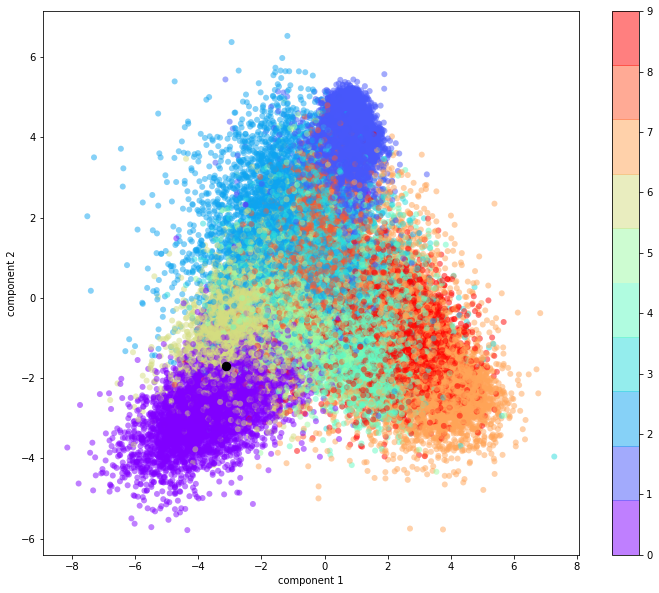

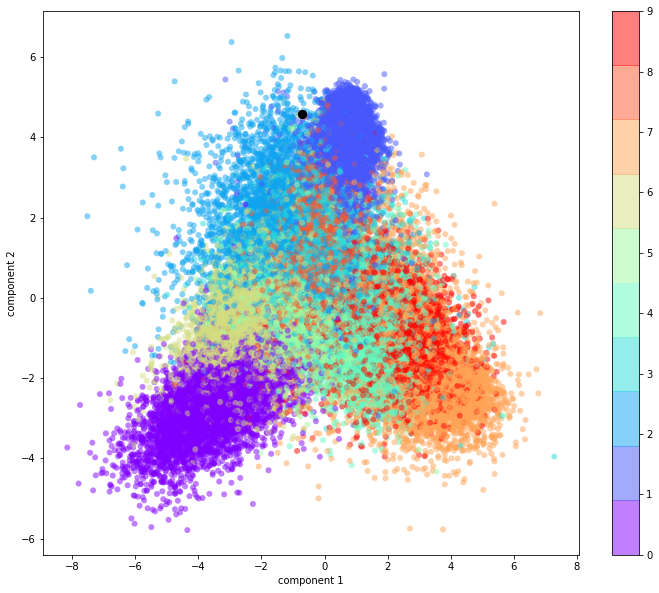

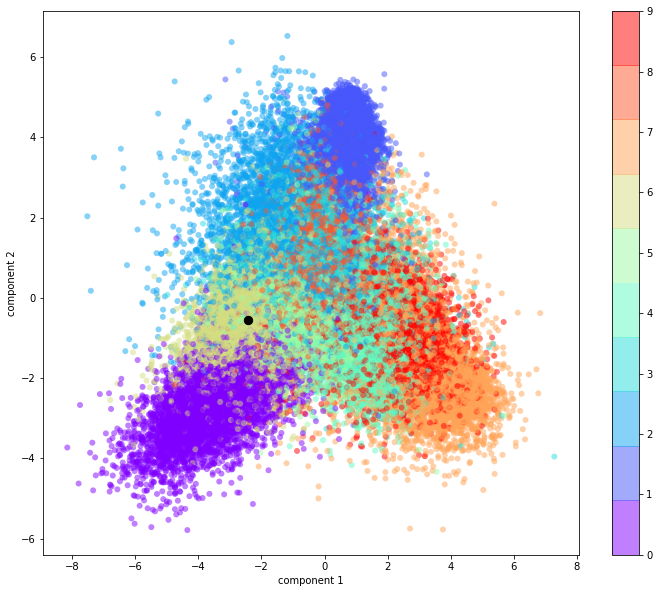

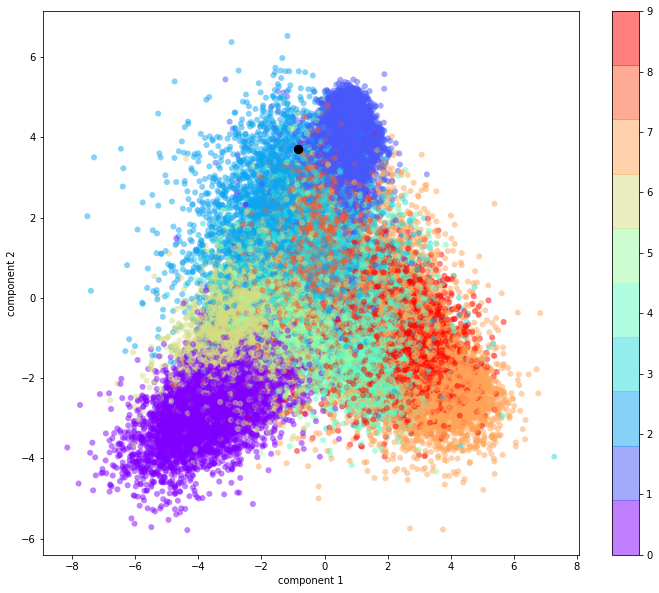

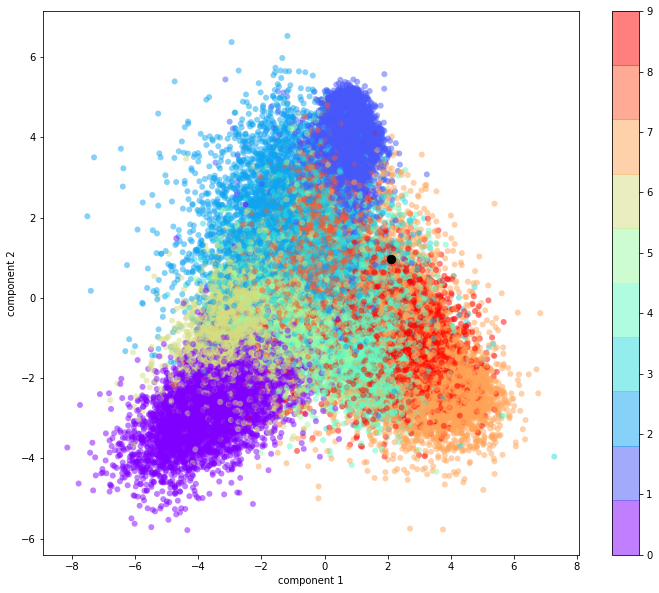

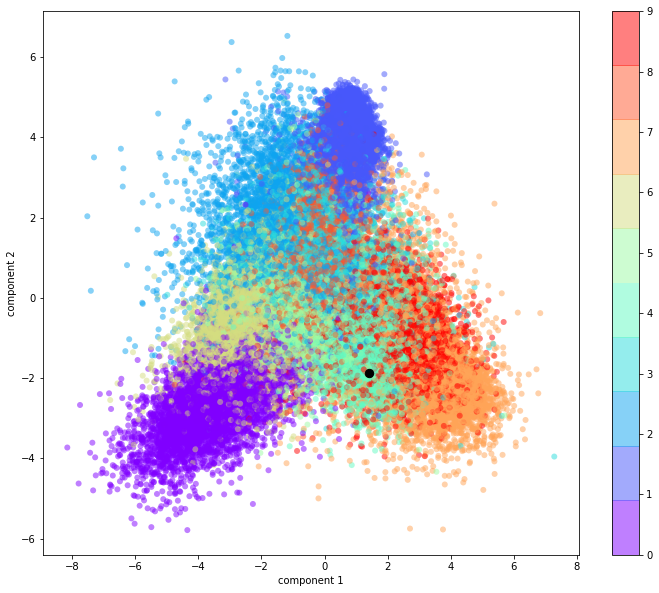

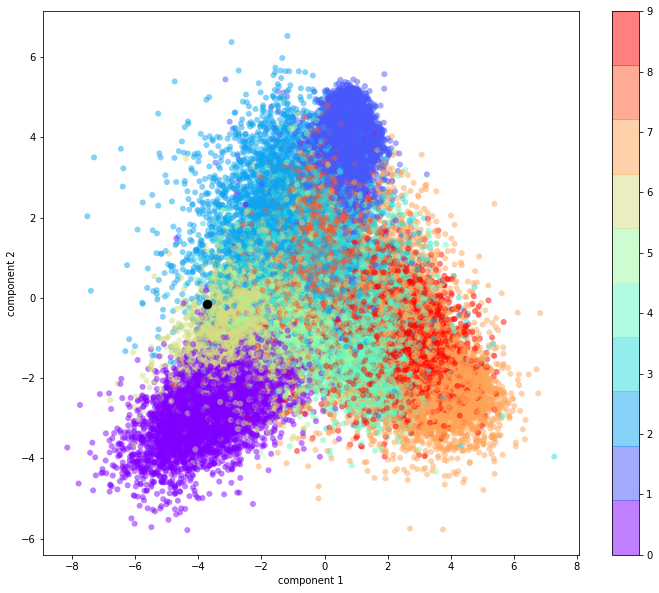

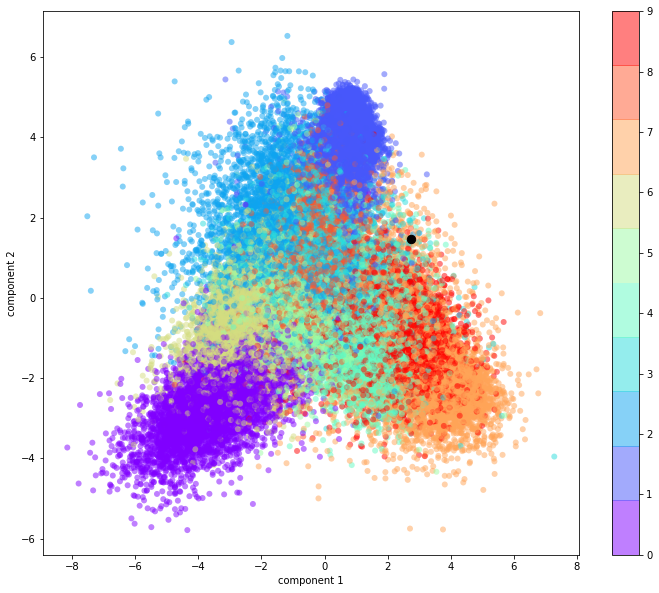

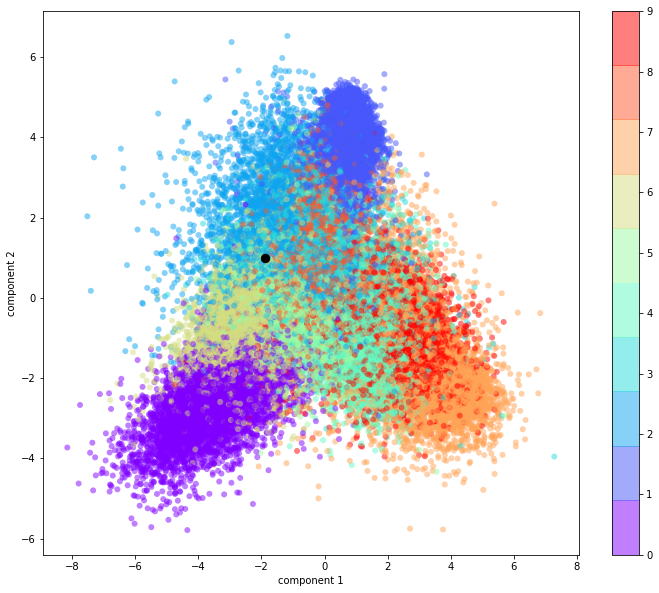

In [6]:
# ejecutamos el applet
root = Tk()
root.geometry("400x400")
root.resizable(0, 0)
app = digits_representation(root)
root.mainloop()    